# Figure 2

imports

In [15]:
import torch, os, sys
import seaborn as sns
from utils.funcs import *
from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM
from utils.poisson_generated_data import PoissonTimeShiftedData
from matplotlib.colors import LogNorm
from scipy.stats import pearsonr
from matplotlib.ticker import LogFormatterExponent

plt.rcParams["font.family"] = "Arial"
plt.rcParams['ytick.labelsize']=7
plt.rcParams['xtick.labelsize']=7

path2dir = r'C:\Users\sebas\OneDrive\Intern\RTRBM'

Set data properties

In [16]:
# number of populations and hidden units
n_h = 10 # 3
neurons_per_population = 20

# create temporal connections
U_hat = create_U_hat(n_h) / 0.15 #/ 0.36

Load data and rtrbm or re-create data and retrain rtrbm

In [17]:
n_runs = 10

train_list = []
test_list = []
rtrbm_list = []
rbm_list = []

if not os.path.isfile(path2dir + '/models/figure2_poisson/run10/rtrbm'):
    for i in range(n_runs):
        # create data
        s = PoissonTimeShiftedData(
            neurons_per_population=20,
            n_populations=n_h,
            n_batches=50,
            norm=1,
            time_steps_per_batch=10000,
            fr_mode='gaussian', frequency_range=[20, 25],
            temporal_connections=U_hat,
        )

        data = reshape(reshape(s.data), T=20, n_batches=2500)
        train, test = data[..., :2000], data[..., 2000:] # shape [n_visible, time, n_batches]

        rtrbm = RTRBM(train, n_hidden=n_h, device='cuda')
        rtrbm.learn(batch_size=10, n_epochs=250, CDk=15, mom=0.9, wc=0.0002,
                    lr_schedule='geometric_decay', min_lr=5e-4, max_lr=5e-3)

        rbm = RBM(reshape(train), n_hidden=n_h, device='cuda')
        rbm.learn(batchsize=100, n_epochs=250, lr=1e-3, CDk=15, mom=0.9, wc=0.0002,
                  lr_schedule='geometric_decay', min_lr=5e-4, max_lr=5e-3)
        train_list += [train]
        test_list += [train]
        rtrbm_list += [rtrbm]
        rbm_list += [rbm]

        torch.save(train, path2dir + '/data/figure2_poisson/run'+str(i+1) +'/train')
        torch.save(test, path2dir + '/data/figure2_poisson/run'+str(i+1) +'/test')
        torch.save(rtrbm, path2dir + '/models/figure2_poisson/run'+str(i+1) + '/rtrbm')
        torch.save(rbm, path2dir + '/models/figure2_poisson/run'+str(i+1) + '/rbm')
else:
    for i in range(n_runs):
        train_list += [torch.load(path2dir + '/data/figure2_poisson/run'+str(i+1) +'/train')]
        test_list += [torch.load(path2dir + '/data/figure2_poisson/run'+str(i+1) +'/test')]
        rtrbm_list += [torch.load(path2dir + '/models/figure2_poisson/run'+str(i+1) + '/rtrbm')]
        rbm_list += [torch.load(path2dir + '/models/figure2_poisson/run'+str(i+1) + '/rbm')]

rtrbm, rbm = rtrbm_list[0], rbm_list[0]
train, test = train_list[0], test_list[0]

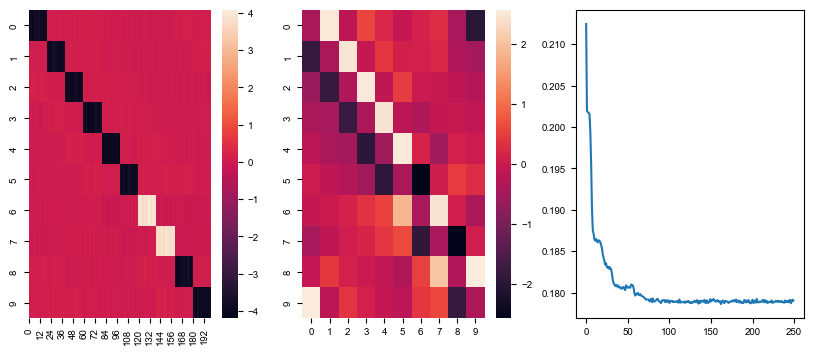

In [18]:
W_hat= torch.zeros_like(rtrbm.W.cpu())
for i in range(n_h):
    W_hat[i:(i+1), i*neurons_per_population:(i+1)*neurons_per_population] = 1

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
W_, U_ = shuffle_back(rtrbm.W.cpu(), rtrbm.U.cpu(), W_true=W_hat, U_true=None)
sns.heatmap(W_, ax=ax[0])
sns.heatmap(U_, ax=ax[1])
ax[2].plot(rtrbm.errors)


In [19]:
vs_rtrbm, hs_rtrbm = rtrbm.sample(torch.tensor(test[:, 0, :]).to(rtrbm.device), chain=test.shape[1], pre_gibbs_k=100, gibbs_k=100)
vs_cRBM, hs_cRBM = rbm.sample(torch.tensor(test[:, 0, :]).to(rbm.device), chain=test.shape[1], pre_gibbs_k=100, gibbs_k=100)
hs_cRBM, _ = rbm.visible_to_hidden(vs_cRBM.to(rbm.device))
ht_rtrbm = reshape(rtrbm._parallel_recurrent_sample_r_given_v(test.to(rtrbm.device)))
ht_cRBM, _ = rbm.visible_to_hidden(reshape(test).to(rbm.device))
vs_rtrbm = reshape(vs_rtrbm)
hs_rtrbm = reshape(hs_rtrbm)
vt = reshape(test)
n_v, T = vt.shape

W, U = shuffle_back(rtrbm.W.cpu(), rtrbm.U.cpu(), W_true=W_hat, U_true=None)
W_rbm = shuffle_back(rbm.W.cpu(), U_trained=None, W_true=W_hat, U_true=None)

C:\Users\sebas\AppData\Local\Temp\ipykernel_10796\2029071175.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vs_rtrbm, hs_rtrbm = rtrbm.sample(torch.tensor(test[:, 0, :]).to(rtrbm.device), chain=test.shape[1], pre_gibbs_k=100, gibbs_k=100)
100%|██████████| 20/20 [00:01<00:00, 11.27it/s]
C:\Users\sebas\AppData\Local\Temp\ipykernel_10796\2029071175.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vs_cRBM, hs_cRBM = rbm.sample(torch.tensor(test[:, 0, :]).to(rbm.device), chain=test.shape[1], pre_gibbs_k=100, gibbs_k=100)
100%|██████████| 21/21 [00:00<00:00, 31.69it/s]


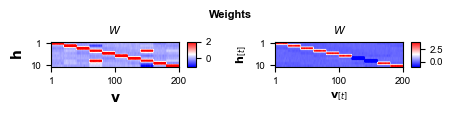

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(4.46, 1))

ax = axes[0]
cm = ax.imshow(-W_rbm, aspect='auto', cmap=plt.get_cmap('bwr'), vmin=-1, vmax=2)
ax.set_title('$W$', fontsize=8)
ax.set_xticks([0, 100, 200])
ax.set_xticklabels([1, 100, 200], fontsize=7)
ax.set_yticks([0, 9])
ax.set_yticklabels([1, 10], fontsize=7)
ax.set_ylabel('$\mathbf{h}$')
ax.set_xlabel('$\mathbf{v}$')
cb = fig.colorbar(cm, ax=ax, aspect=3)
cb.ax.tick_params(labelsize=7)
# cb.ax.set_yticklabels([-1, 2])

ax = axes[1]
cm = ax.imshow(-W, aspect='auto', cmap=plt.get_cmap('bwr'), vmin=-1, vmax=4)
ax.set_title('$W$', fontsize=8)
ax.set_xticks([0, 100, 200])
ax.set_xticklabels([1, 100, 200], fontsize=7)
ax.set_yticks([0, 9])
ax.set_yticklabels([1, 10], fontsize=7)
ax.set_xlabel('$\mathbf{v}_{[t]}$', fontsize=8)
ax.set_ylabel('$\mathbf{h}_{[t]}$', fontsize=8)
cb = fig.colorbar(cm, ax=ax, aspect=3)
# cb.ax.set_yticklabels([-1, 4])
cb.ax.tick_params(labelsize=7)
fig.suptitle('Weights', fontsize=8, fontweight='bold')

plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
#plt.savefig(path2dir + 'RBM_RTRBM_W_10hu.png', dpi=1000)
plt.show()

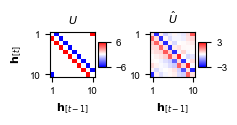

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(2.23, 1))
cm1 = axes[1].imshow(-U, aspect='equal', cmap=plt.get_cmap('bwr'), vmin=-3, vmax=3)
cm2 = axes[0].imshow(create_U_hat(10)/0.17, aspect='equal', cmap=plt.get_cmap('bwr'), vmin=-6, vmax=6)

cb1 = fig.colorbar(cm1, ax=axes[1], shrink=1, aspect=3, ticks=[-3, 3])
cb2 = fig.colorbar(cm2, ax=axes[0], shrink=1, aspect=3, ticks=[-6, 6])
cb1.ax.tick_params(labelsize=7)
cb2.ax.tick_params(labelsize=7)

ax=axes[0]
ax.set_xticks([0, 9])
ax.set_xticklabels([1, 10], fontsize=7)
ax.set_yticks([0, 9])
ax.set_yticklabels([1, 10], fontsize=7)
ax.set_xlabel('$\mathbf{h}_{[t-1]}$', fontsize=8)
ax.set_ylabel('$\mathbf{h}_{[t]}$', fontsize=8)

ax=axes[1]
ax.set_xticks([0, 9])
ax.set_xticklabels([1, 10], fontsize=7)
ax.set_yticks([0, 9])
ax.set_yticklabels([1, 10], fontsize=7)
ax.set_xlabel('$\mathbf{h}_{[t-1]}$', fontsize=8)

axes[1].set_title('$\hat{U}$', fontsize=8)
axes[0].set_title('$U$', fontsize=8)

plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.savefig(path2dir + 'U_U_star2_10hu.png', dpi=1000)

plt.show()

In [22]:
vvs_cRBM = torch.einsum('vT, VT -> vV', vs_cRBM, vs_cRBM) / T
vvs_rtrbm = torch.einsum('vT, VT -> vV', vs_rtrbm, vs_rtrbm) / T
vvt = torch.einsum('vT, VT -> vV', vt, vt) / T

vvs_cRBM_t = torch.einsum('vT, VT -> vV', vs_cRBM[:, :-1], vs_cRBM[:, 1:]) / (T-1)
vvs_rtrbm_t = torch.einsum('vT, VT -> vV', vs_rtrbm[:, :-1], vs_rtrbm[:, 1:]) / (T-1)
vvt_t = torch.einsum('vT, VT -> vV', vt[:, :-1], vt[:, 1:]) / (T-1)

hhs_cRBM_t = torch.einsum('vT, VT -> vV', torch.tensor(hs_cRBM[:, :-1]), torch.tensor(hs_cRBM[:, 1:]))/ (T-1)
hht_cRBM_t = torch.einsum('vT, VT -> vV', torch.tensor(ht_cRBM[:, :-1]), torch.tensor(ht_cRBM[:, 1:]))/ (T-1)
hhs_rtrbm_t = torch.einsum('vT, VT -> vV', hs_rtrbm[:, :-1], hs_rtrbm[:, 1:]) / (T-1)
hht_rtrbm_t = torch.einsum('vT, VT -> vV', ht_rtrbm[:, :-1], ht_rtrbm[:, 1:]) / (T-1)

vvs_cRBM = vvs_cRBM.flatten().cpu()
vvs_rtrbm = vvs_rtrbm.flatten().cpu()
vvt = vvt.flatten().cpu()

vvs_cRBM_t = vvs_cRBM_t.flatten().cpu()
vvs_rtrbm_t = vvs_rtrbm_t.flatten().cpu()
vvt_t = vvt_t.flatten().cpu()

hhs_cRBM_t = hhs_cRBM_t.flatten().cpu()
hht_cRBM_t = hht_cRBM_t.flatten().cpu()

hhs_rtrbm_t = hhs_rtrbm_t.flatten().cpu()
hht_rtrbm_t = hht_rtrbm_t.flatten().cpu()


C:\Users\sebas\AppData\Local\Temp\ipykernel_10796\3861092116.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hhs_cRBM_t = torch.einsum('vT, VT -> vV', torch.tensor(hs_cRBM[:, :-1]), torch.tensor(hs_cRBM[:, 1:]))/ (T-1)
C:\Users\sebas\AppData\Local\Temp\ipykernel_10796\3861092116.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hht_cRBM_t = torch.einsum('vT, VT -> vV', torch.tensor(ht_cRBM[:, :-1]), torch.tensor(ht_cRBM[:, 1:]))/ (T-1)


In [23]:
def density_scatter(x, y, ax=None, fig=None, r=None, vmax=None, n_bins=100, last=False):
    if ax is None:
        fig, ax = plt.subplots()

    x, y = np.array(x), np.array(y)
    x[np.isnan(x)], y[np.isnan(y)]  = 0, 0
    ax.scatter(x, y, s=0.5)
    temp = y - x
    sSSD = np.sqrt(np.dot(temp.T, temp))
    if r is None:
        r, pvalue = pearsonr(x, y)
    ax.text(.05, .9, '$r_p=%0.4s$'%(r), transform=ax.transAxes, fontsize=5, fontweight='heavy')
    ax.text(.05, .75, '$\\sqrt{SSD}=%0.4s$'%(sSSD), transform=ax.transAxes, fontsize=5, fontweight='heavy')
    # print(pvalue)
    # print(ranksums(x, y))
    return ax

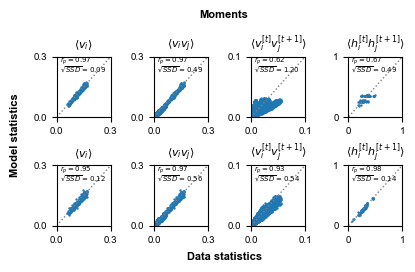

In [24]:
fig, axes = plt.subplots(2, 4, figsize=(4.46, 2.6))
fig.subplots_adjust(top=0.8, bottom=0.15, wspace=0.8, hspace=0.8)

ax = axes[0, 0]
ax = density_scatter(torch.mean(vt, 1), torch.mean(vs_cRBM, 1), ax=ax, fig=fig, vmax=1e3)
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .3])
ax.set_ylim([0, .3])
ax.set_xticks([0, .3])
ax.set_yticks([0, .3])
ax.set_title('$\langle v_i \\rangle$', fontsize=8)
ax.tick_params(labelsize=7)

ax = axes[0, 1]
ax = density_scatter(vvt, vvs_cRBM, ax=ax, fig=fig, vmax=1e3)
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .3])
ax.set_ylim([0, .3])
ax.set_xticks([0, .3])
ax.set_yticks([0, .3])
ax.set_title('$\langle v_iv_j \\rangle$', fontsize=8)
#ax.set_title('$\langle v_iv_j \\rangle-\langle v_i \\rangle \langle v_j \\rangle$', fontsize=fs)
ax.tick_params(labelsize=7)

ax = axes[0, 2]
ax = density_scatter(vvt_t, vvs_cRBM_t, ax=ax, fig=fig, vmax=1e3)
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .1])
ax.set_ylim([0, .1])
ax.set_xticks([0, .1])
ax.set_yticks([0, .1])
ax.set_title('$\langle v_i^{[t]}v_j^{[t+1]} \\rangle$', fontsize=8)
ax.tick_params(labelsize=7)

ax = axes[0, 3]
ax = density_scatter(hht_cRBM_t, hhs_cRBM_t, ax=ax, fig=fig, vmax=1e3)
ax.plot([-5, 5], [-5, 5], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_title('$\langle h_i^{[t]}h_j^{[t+1]} \\rangle$', fontsize=8)
ax.tick_params(labelsize=7)

ax=axes[1, 0]
ax = density_scatter(np.mean(np.array(vt), 1), np.mean(np.array(vs_rtrbm), 1), ax=ax, fig=fig, vmax=1e3)
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .3])
ax.set_ylim([0, .3])
ax.set_xticks([0, .3])
ax.set_yticks([0, .3])
ax.set_title('$\langle v_i \\rangle$', fontsize=8)
ax.tick_params(labelsize=7)

ax = axes[1, 1]
ax = density_scatter(vvt, vvs_rtrbm, ax=ax, fig=fig, vmax=1e3)
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
# ax.plot(covt.flatten(), covs.flatten(), '.', markersize=1)
ax.set_xlim([0, 0.3])
ax.set_ylim([0, 0.3])
ax.set_xticks([0, 0.3])
ax.set_yticks([0, 0.3])
ax.set_title('$\langle v_iv_j \\rangle$', fontsize=8)
#ax.set_title('$\langle v_iv_j \\rangle-\langle v_i \\rangle \langle v_j \\rangle$', fontsize=fs)
ax.tick_params(labelsize=7)

ax = axes[1, 2]
ax = density_scatter(vvt_t, vvs_rtrbm_t, ax=ax, fig=fig, vmax=1e3)
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .1])
ax.set_ylim([0, .1])
ax.set_xticks([0, .1])
ax.set_yticks([0, .1])
ax.set_title('$\langle v_i^{[t]}v_j^{[t+1]} \\rangle$', fontsize=8)
ax.tick_params(labelsize=7)

ax = axes[1, 3]
ax = density_scatter(hht_rtrbm_t, hhs_rtrbm_t, ax=ax, fig=fig, vmax=1e3, last=True)
ax.plot([0, 2], [0, 2], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_title('$\langle h_i^{[t]}h_j^{[t+1]} \\rangle$', fontsize=8)
ax.tick_params(labelsize=7)

fig.suptitle('Moments', fontsize=8, fontweight='bold')
fig.supxlabel('Data statistics', fontsize=8, fontweight='bold')
fig.supylabel('Model statistics', fontsize=8, fontweight='bold')

plt.show()

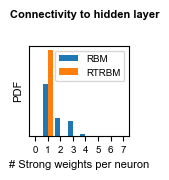

In [25]:
av_conn_rtrbm = torch.sum(torch.abs(rtrbm.W.cpu()) > .5*torch.std(rtrbm.W.cpu()), 0)
av_conn_rbm = torch.sum(torch.abs(rbm.W.cpu()) > .5*torch.std(rbm.W.cpu()), 0)

n_conn_rbm, counts_rbm = torch.unique(av_conn_rbm, return_counts=True)
n_conn_rtrbm, counts_rtrbm = torch.unique(av_conn_rtrbm, return_counts=True)

fig, ax = plt.subplots(figsize=(2.23, 2))
ax.bar(n_conn_rbm - .2, counts_rbm / torch.sum(counts_rbm), width=.4, label='RBM')
ax.bar(n_conn_rtrbm + .2, counts_rtrbm / torch.sum(counts_rtrbm), width=.4, label='RTRBM')

ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7], fontsize=7)
ax.set_xlim([-.5, 7.5])
ax.set_ylabel('PDF', fontsize=8)
#ax.set_ylabel('log(PDF)', fontsize=8)
#ax.set_yscale('log')
fig.suptitle('Connectivity to hidden layer', fontsize=8, fontweight='bold')
ax.set_xlabel('# Strong weights per neuron', fontsize=8)
ax.set_yticks([])
ax.set_box_aspect()

fig.legend(fontsize=7, loc='upper right', bbox_to_anchor=(.7, .8))
plt.tight_layout(pad=.2, h_pad=.2, w_pad=.2)
plt.subplots_adjust(left=0.25, bottom=0.35, right=0.7, top=0.8)
plt.show()

In [26]:
rmse_rbm = torch.zeros(n_runs)
rv_rbm = torch.zeros(n_runs)
rvv_rbm = torch.zeros(n_runs)
rvt_rbm = torch.zeros(n_runs)
rht_rbm = torch.zeros(n_runs)
rmse_rtrbm = torch.zeros(n_runs)
rv_rtrbm = torch.zeros(n_runs)
rvv_rtrbm = torch.zeros(n_runs)
rvt_rtrbm = torch.zeros(n_runs)
rht_rtrbm = torch.zeros(n_runs)

for i in tqdm(range(n_runs)):

    train = train_list[i]
    test = test_list[i]
    rtrbm = rtrbm_list[i]
    rbm = rbm_list[i]

    # reshape data
    vt = reshape(test)
    vs_rtrbm, hs_rtrbm = rtrbm.sample(torch.tensor(test[:, 0, :]).to(rtrbm.device), chain=test.shape[1]
                                      , pre_gibbs_k=4000, gibbs_k=100, disable_tqdm=True)
    vs_rbm, hs_rbm = rbm.sample(torch.tensor(test[:, 0, :]).to(rbm.device), chain=test.shape[1]
                                      , pre_gibbs_k=4000, gibbs_k=100, disable_tqdm=True)
    hs_rbm, _ = rbm.visible_to_hidden(vs_rbm.to(rbm.device))
    ht_rtrbm = reshape(rtrbm._parallel_recurrent_sample_r_given_v(test.to(rtrbm.device)))
    ht_rbm, _ = rbm.visible_to_hidden(vt.to(rbm.device))
    vs_rtrbm = reshape(vs_rtrbm)
    hs_rtrbm = reshape(hs_rtrbm)
    T = vt.shape[1]

    # calculate moments
    vvs_rbm = torch.einsum('vT, VT -> vV', vs_rbm, vs_rbm) / T
    vvs_rtrbm = torch.einsum('vT, VT -> vV', vs_rtrbm, vs_rtrbm) / T
    vvt = torch.einsum('vT, VT -> vV', vt, vt) / T

    vvs_rbm_t = torch.einsum('vT, VT -> vV', vs_rbm[:, :-1], vs_rbm[:, 1:]) / (T-1)
    vvs_rtrbm_t = torch.einsum('vT, VT -> vV', vs_rtrbm[:, :-1], vs_rtrbm[:, 1:]) / (T-1)
    vvt_t = torch.einsum('vT, VT -> vV', vt[:, :-1], vt[:, 1:]) / (T-1)

    hhs_rbm_t = torch.einsum('vT, VT -> vV', torch.tensor(hs_rbm[:, :-1]), torch.tensor(hs_rbm[:, 1:]))/ (T-1)
    hht_rbm_t = torch.einsum('vT, VT -> vV', torch.tensor(ht_rbm[:, :-1]), torch.tensor(ht_rbm[:, 1:]))/ (T-1)
    hhs_rtrbm_t = torch.einsum('vT, VT -> vV', hs_rtrbm[:, :-1], hs_rtrbm[:, 1:]) / (T-1)
    hht_rtrbm_t = torch.einsum('vT, VT -> vV', ht_rtrbm[:, :-1], ht_rtrbm[:, 1:]) / (T-1)

    vvs_rbm = vvs_rbm.flatten().cpu()
    vvs_rtrbm = vvs_rtrbm.flatten().cpu()
    vvt = vvt.flatten().cpu()

    vvs_rbm_t = vvs_rbm_t.flatten().cpu()
    vvs_rtrbm_t = vvs_rtrbm_t.flatten().cpu()
    vvt_t = vvt_t.flatten().cpu()

    hhs_rbm_t = hhs_rbm_t.flatten().cpu()
    hht_rbm_t = hht_rbm_t.flatten().cpu()

    hhs_rtrbm_t = hhs_rtrbm_t.flatten().cpu()
    hht_rtrbm_t = hht_rtrbm_t.flatten().cpu()

    # calculate correlations
    rmse_rbm[i] = torch.mean((vs_rbm - vt)**2)
    rv_rbm[i], _ = pearsonr(torch.mean(vs_rbm, 1), torch.mean(vt, 1))
    rvv_rbm[i], _ = pearsonr(vvs_rbm, vvt)
    rvt_rbm[i], _ = pearsonr(vvs_rbm_t, vvt_t)
    rht_rbm[i], _ = pearsonr(hhs_rbm_t, hht_rbm_t)
    rmse_rtrbm[i] = torch.mean((vs_rtrbm - vt)**2)
    rv_rtrbm[i], _ = pearsonr(torch.mean(vs_rtrbm, 1), torch.mean(vt, 1))
    rvv_rtrbm[i], _ = pearsonr(vvs_rtrbm, vvt)
    rvt_rtrbm[i], _ = pearsonr(vvs_rtrbm_t, vvt_t)
    rht_rtrbm[i], _ = pearsonr(hhs_rtrbm_t, hht_rtrbm_t)


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\sebas\AppData\Local\Temp\ipykernel_10796\601750969.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vs_rtrbm, hs_rtrbm = rtrbm.sample(torch.tensor(test[:, 0, :]).to(rtrbm.device), chain=test.shape[1]
C:\Users\sebas\AppData\Local\Temp\ipykernel_10796\601750969.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vs_rbm, hs_rbm = rbm.sample(torch.tensor(test[:, 0, :]).to(rbm.device), chain=test.shape[1]
C:\Users\sebas\AppData\Local\Temp\ipykernel_10796\601750969.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch

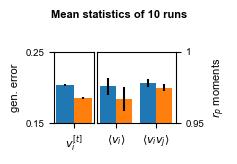

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(2.23, 1.5), gridspec_kw={'width_ratios':[1, 2]})

ax = axes[0]
ax.bar(.8, torch.mean(rmse_rbm), yerr=torch.std(rmse_rbm), label="RBM", width=.4)
ax.bar(1.2, torch.mean(rmse_rtrbm)-0.02, yerr=torch.std(rmse_rtrbm), label="RTRBM", width=.4)
ax.set_ylabel('gen. error', fontsize=8)
ax.set_ylim([0.15, .25])
ax.set_xticks([1.])
ax.set_xticklabels([r'$v_i^{[t]}$'], fontsize=8)
ax.set_yticks([.15, .25])
ax.set_yticklabels([.15, .25], fontsize=7)

ax = axes[1]
ax.bar(
    torch.arange(2) - .2,
    [torch.mean(rv_rbm), torch.mean(rvv_rbm)],
    yerr=[torch.std(rv_rbm), torch.std(rvv_rbm)],
    label='RBM',
    width=.4
)
ax.bar(
    torch.arange(2) + .2,
    [torch.mean(rv_rtrbm), torch.mean(rvv_rtrbm)],
    yerr=[torch.std(rv_rtrbm), torch.std(rvv_rtrbm)],
    label='RTRBM',
    width=.4
)

ax.set_ylim([0.95, 1])
ax.set_ylabel('$r_p$ moments', fontsize=8)
ax.set_xticks([0, 1])
ax.set_xticklabels([r'$\langle v_i \rangle$', r'$\langle v_iv_j \rangle$'], fontsize=8)
ax.set_yticks([0.95, 1])
ax.set_yticklabels([0.95, 1], fontsize=7)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

fig.suptitle('Mean statistics of 10 runs', fontsize=8, fontweight='bold')
plt.tight_layout(pad=0.2, h_pad=0, w_pad=0.2)
fig.subplots_adjust(top=0.7)
plt.show()

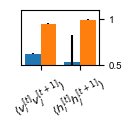

In [28]:
fig, axes = plt.subplots(figsize=(1.15, 1.2))

ax = axes
ax.bar(
    torch.arange(2) - .2,
    [torch.mean(rvt_rbm), torch.mean(rht_rbm)],
    yerr=[torch.std(rvt_rbm), torch.std(rht_rbm)],
    label='RBM',
    width=.4
)
ax.bar(
    torch.arange(2) + .2,
    [torch.mean(rvt_rtrbm), torch.mean(rht_rtrbm)],
    yerr=[torch.std(rvt_rtrbm), torch.std(rht_rtrbm)],
    label='RTRBM',
    width=.4
)
ax.set_ylim([.5, 1.1])
# ax.set_ylabel('$r_p$ moments', fontsize=8)
ax.set_xticks([0, 1])
ax.set_xticklabels([r'$\langle v_i^{[t]} v_j^{[t+1]} \rangle$', r'$\langle h_i^{[t]} h_j^{[t+1]} \rangle$'],
                   fontsize=8, rotation=30)
ax.set_yticks([.5, 1])
ax.set_yticklabels([.5, 1], fontsize=7)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.tight_layout(pad=0.2, h_pad=0, w_pad=0.2)

plt.show()
